# MRI-3T-taskfMRI

**Overview**

In this notebook, we will analyze with the Mneumonic Similarity Task (MST). This is divided into a few sections:

0) A full walkthrough of one subject analysis (mapping data to surfaces, creating a design matrix, difining contrasts, and then fitting the actual timeseries data)

1) Loading data from all subjects and plotting group-level data,

2) Significance/reliability testing

3) Applying the same to the neocortex instead of hippocampus, and 

4) Contextualizing resulting hippocampal maps by direct spatial correlation to other HippoMaps features


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
import pickle
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings("ignore")
import time
start_time = time.time()

In [2]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI_samplesubject-MST.npz'])
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI_betas-MST.npz'])
    
# locate input data
ses = '01'
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_MICs/rawdata/' # this we need for the events.tsv files
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

# define which subjects and surfaces to examine
subs = [
 'HC001', 'HC002', 'HC005', 'HC006', 'HC007', 'HC011', 'HC012', 'HC013', 'HC014', 'HC015',
 'HC016', 'HC017', 'HC018', 'HC019', 'HC020', 'HC021', 'HC022', 'HC023', 'HC025', 'HC026',
 'HC027', 'HC028', 'HC029', 'HC030', 'HC031', 'HC032', 'HC033', 'HC034', 'HC035', 'HC036', 
 'HC037', 'HC038', 'HC039', 'HC040', 'HC041', 'HC042', 'HC043', 'HC044', 'HC045', 'HC046', 
 'HC047', 'HC048', 'HC049', 'HC050', 'HC051', 'HC052', 'HC053', 'HC054', 'HC055', 'HC056', 
 'HC057', 'HC058', 'HC059', 'HC060', 'HC061', 'HC063', 'HC065', 'HC067', 'HC068', 'HC069', 
 'HC070', 'HC071', 'HC072', 'HC074', 'HC075', 'HC077', 'HC078', 'HC081', 'HC082', 'HC084', 
 'HC086', 'HC087', 'HC088', 'HC089', 'HC090', 'HC093', 'HC097', 'HC100', 'HC024', 'HC064', 
 'HC073', 'HC101']
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
den='2mm'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# fMRI options
sigma = 1 # Gaussian smoothing kernal sigma (mm) to apply to surface data
TR = 0.6 # repetition time (seconds)
task= 'MST2'
slice_time_ref = 0.0
nVolumes=850 # Max timeseries length (will be padded with NaNs if the run is shorter)
hrf_model = 'spm + derivative + dispersion'
tmp_dir = 'tmp_fMRI_3T'

# 3. Load neocortical surfaces for visualzation
parcL, parcR = load_parcellation('schaefer')
parc = np.concatenate((parcL, parcR))
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
c69_inf_lh, c69_inf_rh = load_conte69()

## 0) Single-subject walkthrough

Since fMRI processing is relatively heavy, we provide a tutorial walkthrough GLM for one subject. Subsequent analyses are loaded from a checkpoint for all subjects

In [3]:
s=0
sub = subs[s]

## 0.1) Map data to hippocampal surface

In this example, we loop through subjects and hemispheres, and sample volumetric timeseries data onto hippocampal surfaces. We then apply smoothing. Finally, we save the data from all surfaces into `.func.gii` files.

Note that here we run only one subject, but all subjects can easily be enumerated!

In [4]:
if not useCheckpoints:
    !mkdir -p {tmp_dir}

    cdata_hipp = np.ones((nV,len(hemis),nVolumes,1))*np.nan
    neo_ts = np.ones((nP,len(hemis),nVolumes,1))*np.nan
    all_events = np.empty((1),dtype=object)
    all_motion_reg = np.empty((1),dtype=object)

    # events and regressors
    all_events[s] = pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_events.tsv')
    all_motion_reg[s] = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')

    # convert affines 
    cmd1a = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-{task}_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
    !{cmd1a}
    cmd1b = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
        f'-inv '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
    !{cmd1b}
    
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            #apply affines
            cmd2a = f'wb_command -surface-apply-affine '\
                f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'
            !{cmd2a}
            cmd2b = f'wb_command -surface-apply-affine '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
            !{cmd2b}
            # apply warp (Note this is actually the INVERSE warp)
            cmd3 = f'wb_command -surface-apply-warpfield '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
            !{cmd3}

            # sample
            cmd4 = f'wb_command -volume-to-surface-mapping '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                f'-enclosing'
            !{cmd4}

            # smooth
            cmd5 = f'wb_command -metric-smoothing '\
                f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                f'{sigma} '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
            !{cmd5}

            # load mapped hippocmapal surface data
            func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
            for k in range(len(func.darrays)):
                cdata_hipp[iV[l],h,k,s] = func.darrays[k].data

            # Load the neocortical timeseries in fsLR32k and dowmsample to schaefer 400 space
            func = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
            func_parc = np.ones((int(nP*2),nVolumes))*np.nan
            for i in range(int(nP*2)):
                for k in range(func.shape[0]):
                    func_parc[i,k] = np.nanmean(func[k, parc == (i + 1)])
            neo_ts[:,:,:,s] = func_parc.reshape((nP,2,nVolumes))

    np.savez_compressed("checkpoints/MRI-3T-taskfMRI_samplesubject-MST", cdata_hipp, neo_ts, all_events, all_motion_reg)
    !rm -r {tmp_dir}

## 0.2) Create design matrix

First we will walk through how this can be done for one subject, and in principle, we will loop through all subjects. This tutorial will skip this loop for the sake of being lightweight.

In [5]:
loaddat = np.load("checkpoints/MRI-3T-taskfMRI_samplesubject-MST.npz", allow_pickle=True)
hipp_ts = loaddat['arr_0']
neo_ts = loaddat['arr_1']
all_events = loaddat['arr_2']
all_motion_reg = loaddat['arr_3']

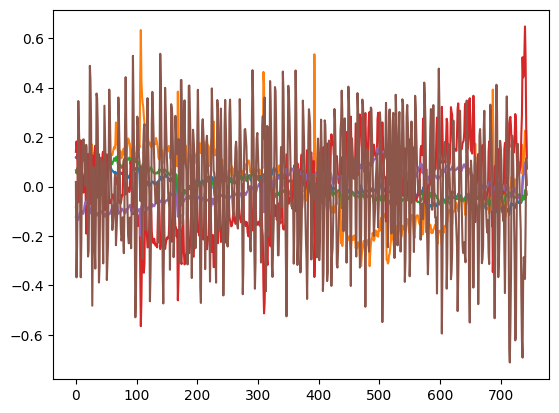

In [6]:
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']

# examine regressors of no interest generated by micapipe
motion_reg = all_motion_reg[s]
nTRs = motion_reg.shape[0]
# Specify the timing of fmri frames
frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

plt.plot(motion_reg);

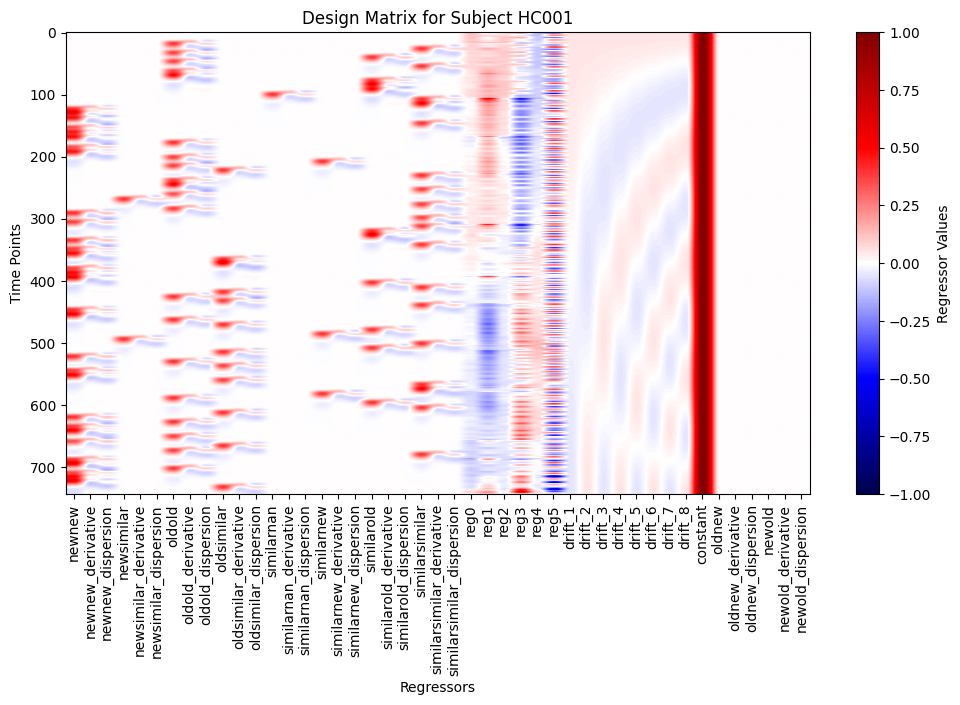

In [7]:
# create design matrix

# Load event files
events = all_events[s]
df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
# Recode events to have easy-to-read names
df = df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'})
# Combine response and condition to get all possible combinations
true_con = events['trial_type'] + events["subject response"].astype('str')
df['trial_type'] = true_con

design_matrix = make_first_level_design_matrix(frame_times,
                                              events=df,
                                              hrf_model=hrf_model,
                                              add_regs=motion_reg)

# in some cases, there are no trials of a certain type (eg. someone never pressed "new" to and "old" stimulus.
# in this case add extra columns to the design matrix with all 0s
# this will help us look at all trial types later
for condition in conditions:
    if condition not in design_matrix.columns:
        # Create columns for condition, its derivatives, and dispersion
        design_matrix[condition] = 0
        design_matrix[f'{condition}_derivative'] = 0
        design_matrix[f'{condition}_dispersion'] = 0    
        
# plot design matrix
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

## 0.3) Define contrasts

In [8]:
# nibabel expects contrasts to be defined as a dictionary. Here, we first make a dictionary of basic contrasts for each column of our design matrix (1 for that column, 0 for all others)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
            for i, column in enumerate(design_matrix.columns)])

# now we define actual contrasts of interest for each trial type, without subtracting any other trial type (i.e. uncorrected)
contrasts = {
'patternseparation_uncorrected': (
    basic_contrasts['similarsimilar']
    + basic_contrasts['similarsimilar_derivative']
    + basic_contrasts['similarsimilar_dispersion']),
'patterncompletion_uncorrected': (
    basic_contrasts['oldsimilar']
    + basic_contrasts['oldsimilar_derivative']
    + basic_contrasts['oldsimilar_dispersion']),
'noveltydetection_uncorrected': (
    basic_contrasts['newnew']
    + basic_contrasts['newnew_derivative']
    + basic_contrasts['newnew_dispersion']),
# now we will subtract trials where the subject "failed" the trial type of interest
'patternseparation': (
    basic_contrasts['similarsimilar']
    - basic_contrasts['similarnew']
    + basic_contrasts['similarsimilar_derivative']
    - basic_contrasts['similarnew_derivative']
    + basic_contrasts['similarsimilar_dispersion']
    - basic_contrasts['similarnew_dispersion']),
'patterncompletion': (
    basic_contrasts['oldsimilar']
    - basic_contrasts['oldnew']
    + basic_contrasts['oldsimilar_derivative']
    - basic_contrasts['oldnew_derivative']
    + basic_contrasts['oldsimilar_dispersion']
    - basic_contrasts['oldnew_dispersion']),
'noveltydetection': (
    basic_contrasts['newnew']
    - 0.5*basic_contrasts['oldsimilar']
    - 0.5*basic_contrasts['oldnew']
    + basic_contrasts['newnew_derivative']
    - 0.5*basic_contrasts['oldsimilar_derivative']
    - 0.5*basic_contrasts['oldnew_derivative']
    + basic_contrasts['newnew_dispersion']
    - 0.5*basic_contrasts['oldsimilar_dispersion']
    - 0.5*basic_contrasts['oldnew_dispersion'])}

contrasts

{'patternseparation_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patterncompletion_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'noveltydetection_uncorrected': array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patternseparation': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 'pa

## 0.4) Fit the timeseries data

We apply this once to the hippocmapal timeseries `hipp_ts`, and then again to `neo_ts`

In [9]:
nContrasts=6
contrasts_patternsep2 = np.ones((nV, len(hemis), nContrasts))*np.nan # 6 different contrasts will be considered
contrasts_patternsep2_neo = np.ones((nP, len(hemis), nContrasts)) * np.nan

for h, hemi in enumerate(hemis):

    ### fit the design matrix to the data
    labels_, estimates = run_glm(hipp_ts[:,h,:nTRs,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it
    labels_neo, estimates_neo = run_glm(neo_ts[:,h,:nTRs,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it

    ### run contrasts of interest
    for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
        contrasts_patternsep2[:,h,c] = contrast.z_score()
        contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
        contrasts_patternsep2_neo[:,h,c] = contrast.z_score()

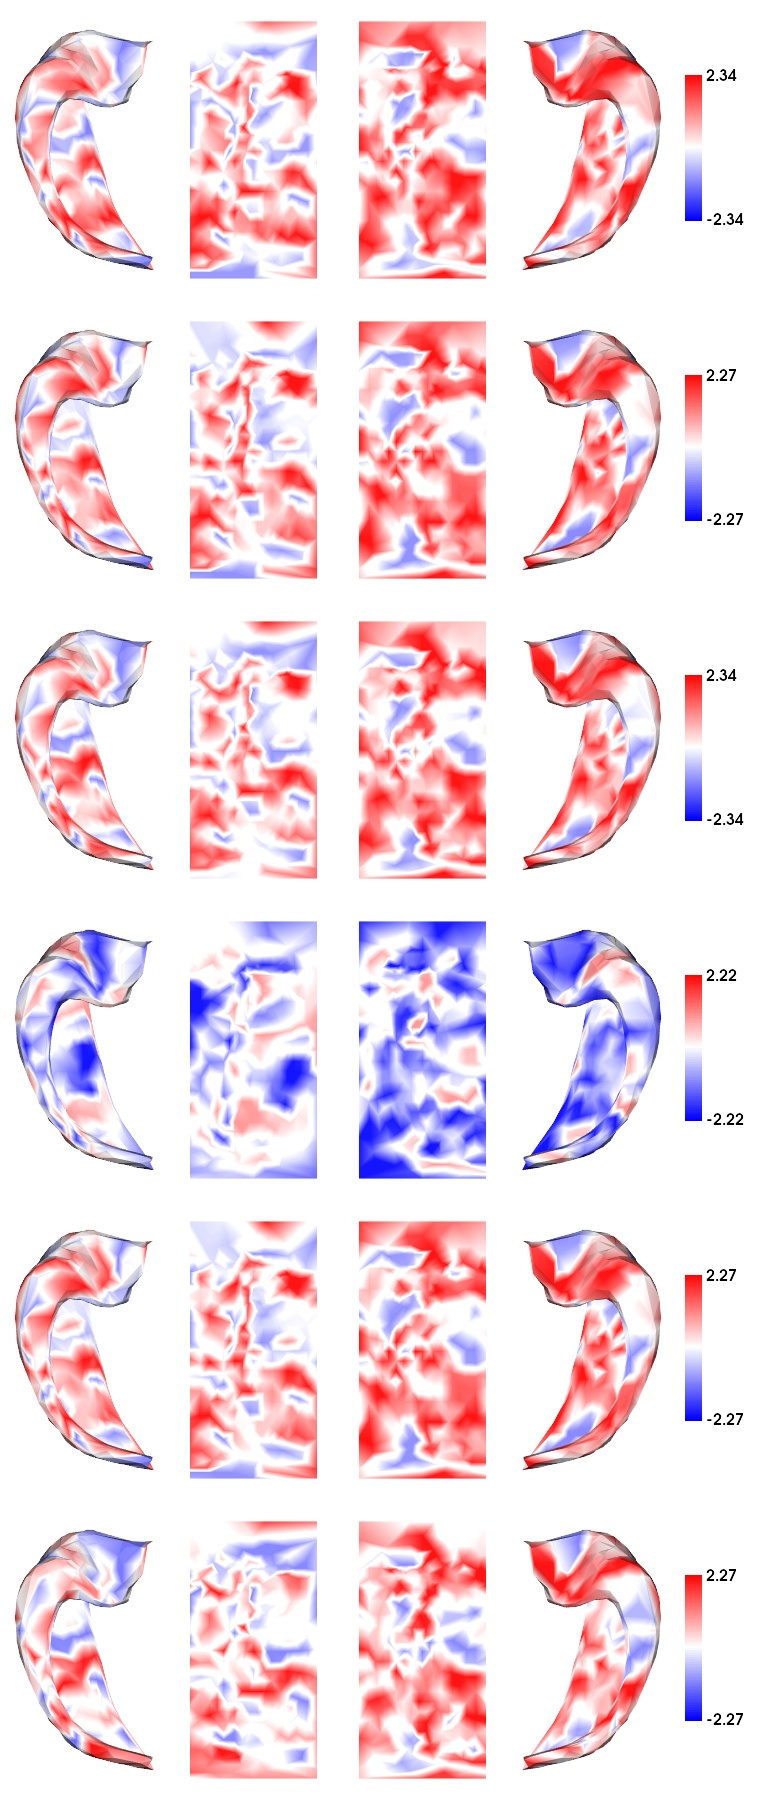

In [10]:
# plot each contrast
hm.plotting.surfplot_canonical_foldunfold(contrasts_patternsep2, den='2mm', hemis=hemis, labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

## 1) Load and plot contrasts from ALL subjects

In [11]:
if not useCheckpoints:
    contrastnames_patternsep2=list(contrasts.keys())
    contrasts_patternsep2 = np.ones((nV, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    contrasts_patternsep2_neo = np.ones((200, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    for s, sub in enumerate(subs):
        for h, hemi in enumerate(hemis):
            for l, label in enumerate(labels):
                for c, contrast_name in enumerate(contrastnames_patternsep2):                 
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-MST2_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_patternsep2[:, h, s, c] = data
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-MST2_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_patternsep2_neo[:,h, s, c] = data  # Corrected indexing
    np.savez_compressed("checkpoints/MRI-3T-taskfMRI_betas-MST", contrasts_patternsep2, contrasts_patternsep2_neo)


In [12]:
loaddat = np.load("checkpoints/MRI-3T-taskfMRI_betas-MST.npz", allow_pickle=True)
contrasts_patternsep2 = loaddat['arr_0']
contrasts_patternsep2_neo = loaddat['arr_1']

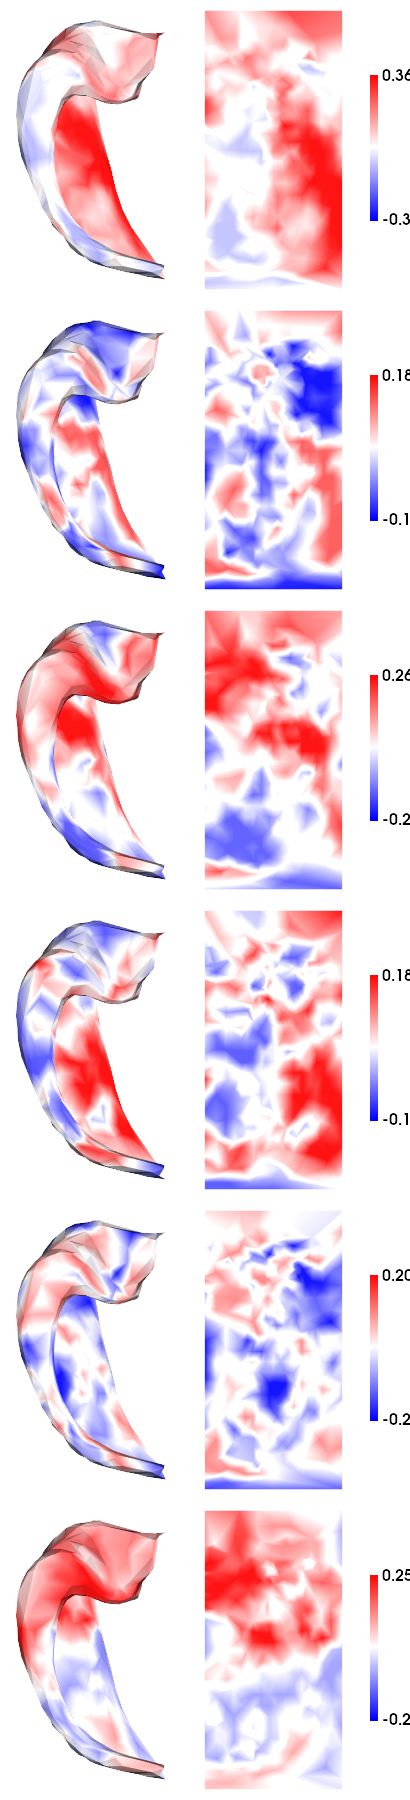

In [13]:
# Group-averaging 
# Note that because there is generally high L/R symmetry, we will average between hemishperes
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

## 2) Significance/reliability testing

We won't go into detail here, but this gives a basic idea of (uncorrected) significance values. Ideally, some cluster correction should be applied, but for simplicity we apply uncorrected ttest against 0.

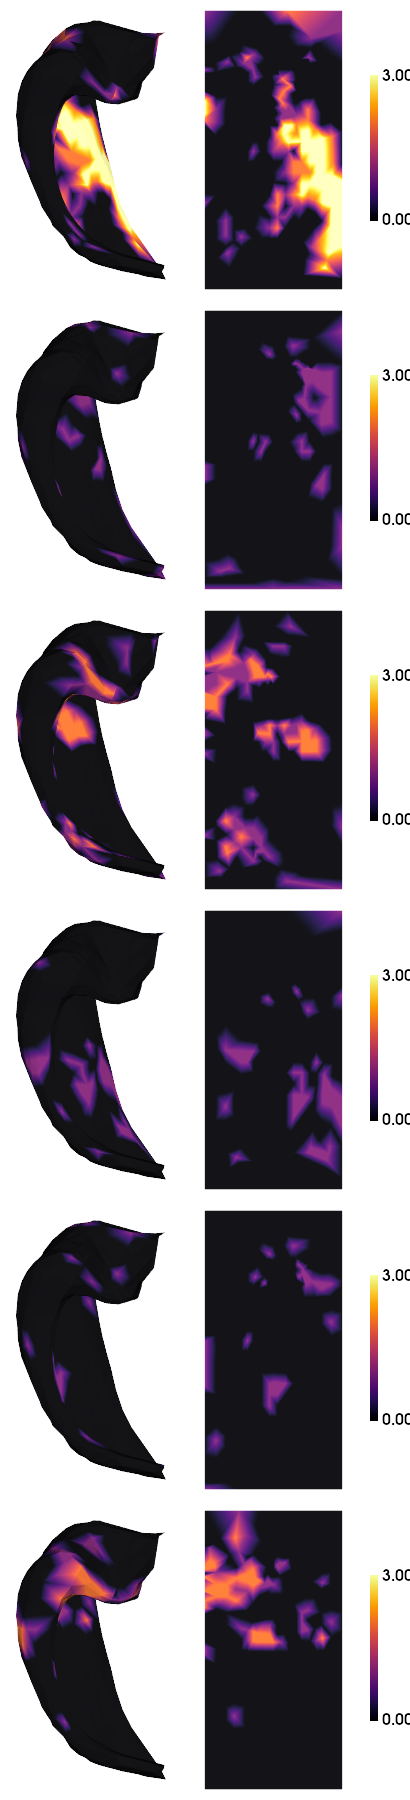

In [14]:
tstats = ttest_1samp(contrasts_patternsep2.reshape(nV,2*len(subs),nContrasts),0,axis=1)
tmap = np.zeros(tstats[1].shape)
tmap[tstats[1]<(0.05)] = 1
tmap[tstats[1]<(0.01)] = 2
tmap[tstats[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

**Additional consistency checks**

Rather than significance, we can also check the correlation (consistency) between subject results. Here we check whether correlations are significantly >0

TtestResult(statistic=9.999337334856799, pvalue=3.3817372890644015e-23, df=3159)
TtestResult(statistic=1.9517708407297705, pvalue=0.051068668356102305, df=2700)
TtestResult(statistic=7.86251505448667, pvalue=5.048768541653393e-15, df=3320)
TtestResult(statistic=2.2011111536571644, pvalue=0.027796743405347733, df=3320)
TtestResult(statistic=0.3003003824283886, pvalue=0.7639673133830844, df=3239)
TtestResult(statistic=3.997247684489162, pvalue=6.547683783811964e-05, df=3320)


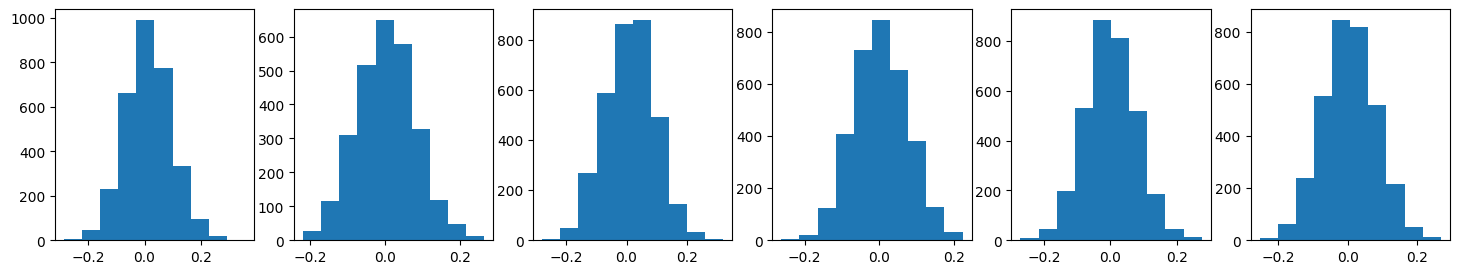

In [28]:
mfcorr = []
sdfcorr = []
allcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_patternsep2[:,:,:,f].reshape((nV*2,-1))
    corr[:,:,h,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr);
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))
    allcorr.append(fcorr)

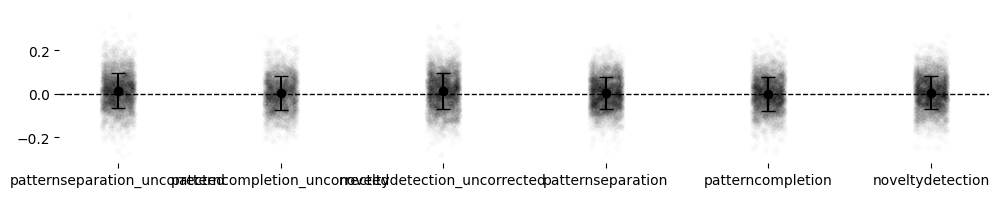

In [31]:
xnames = list(contrasts.keys())

# Generate individual points from provided allcorr data
jitter_strength = 0.1  # Controls horizontal spread

data_points = []
x_positions = np.arange(len(xnames))
for i, points in enumerate(allcorr):
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(points))
    data_points.append((x_positions[i] + jitter, points))

# Plot
fig, ax = plt.subplots(figsize=(2 * len(xnames), 2))
for x, y in data_points:
    ax.scatter(x, y, color='black', alpha=0.01, s=10)  # Individual points in greyscale
ax.errorbar(x_positions, mfcorr, yerr=sdfcorr, fmt='o', color='black', capsize=5)  # Mean and SD line in greyscale

# Remove outer border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add horizontal line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_xticks(x_positions)
ax.set_xticklabels(xnames)
plt.show()

In [17]:
#save the average maps
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,cname in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_patternsep2[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-MST2_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{cname}.shape.gii')

## 3) Consider neocortical results

All the same as above, but with neocortical surfaces

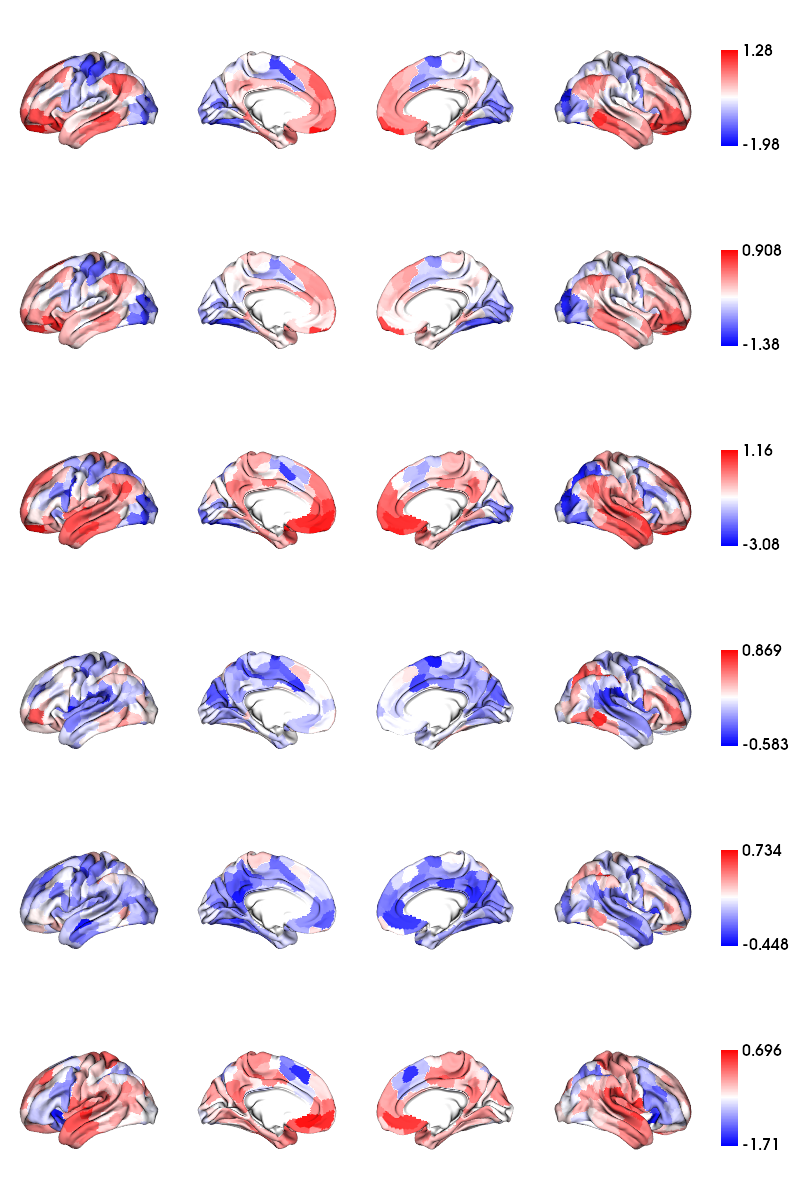

In [18]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP)),c] = np.nanmean(contrasts_patternsep2_neo,axis=2)[i,h,c]
            
plot_hemispheres(c69_inf_lh, c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

TtestResult(statistic=125.44587709572133, pvalue=0.0, df=12719)
TtestResult(statistic=74.74538598254392, pvalue=0.0, df=10877)
TtestResult(statistic=159.34522192002078, pvalue=0.0, df=13365)
TtestResult(statistic=31.226919970854308, pvalue=1.1110902175829445e-206, df=13365)
TtestResult(statistic=13.570987507223824, pvalue=1.1414292911563038e-41, df=13040)
TtestResult(statistic=61.59369873800047, pvalue=0.0, df=13365)


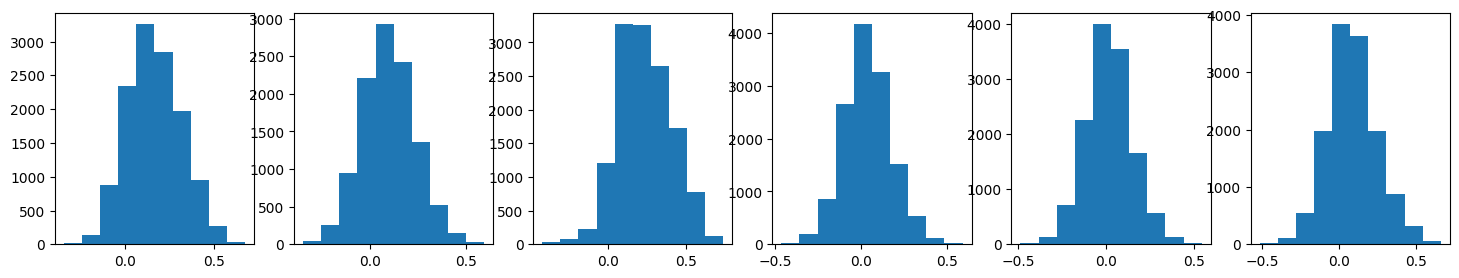

In [19]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_patternsep2_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

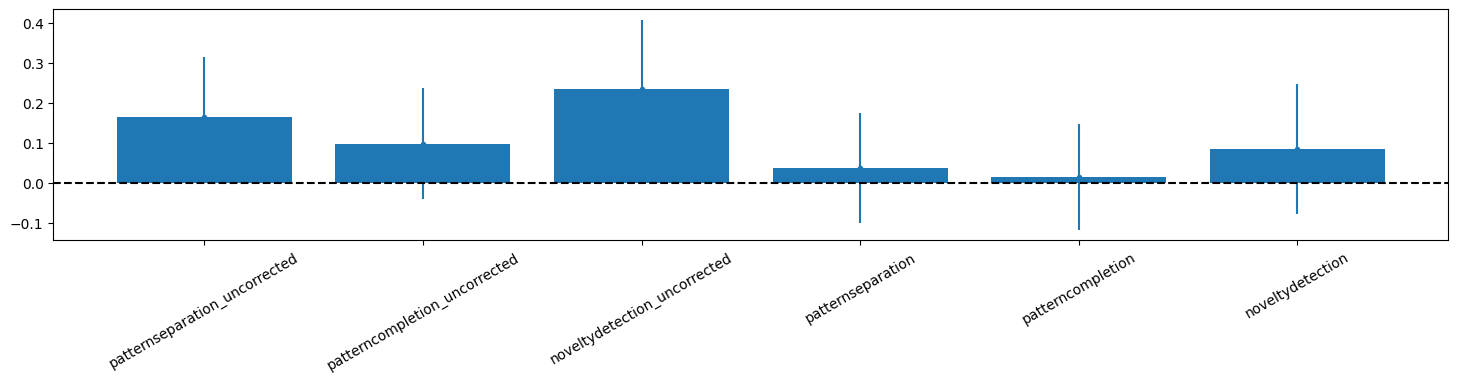

In [20]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*nContrasts,3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 4) Compare to previously mapped features

In HippoMaps, we present a high-order space of all features correlated with a continuous anterior-posterior axis by a discrete proximal-distal subfields. Here, we reload that space to find where the present maps fall, and which other mapped features they are most similar to

In [21]:
# here we look only at the pattern separation and novelty conditions
feats_to_examine = [[0,2]]
cdata = np.nanmean(contrasts_patternsep2,axis=(1,2))[:,feats_to_examine]
# featNames = [xnames[i] for i in feats_to_examine]
featNames = ['PS','Nov']
context2D, ax = hm.stats.contextualize2D(cdata, taskNames=featNames, numerbMaps=True, nperm=10000) # set nperm low for fast testing!

KeyboardInterrupt: 